In [1]:
import kagglehub

path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:16<00:00, 21.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [2]:
import os
os.listdir(path)

['seg_pred', 'seg_test', 'seg_train']

In [3]:
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

In [5]:
classes = os.listdir(train_dir)

image_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in classes
}

image_counts

{'glacier': 2404,
 'street': 2382,
 'buildings': 2191,
 'mountain': 2512,
 'forest': 2271,
 'sea': 2274}

**CLASS DISTRIBUTION**

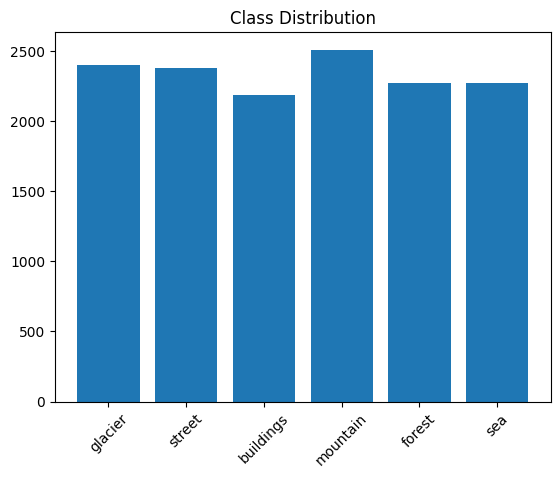

In [6]:
plt.bar(image_counts.keys(), image_counts.values())
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

**SAMPLE IMAGES**

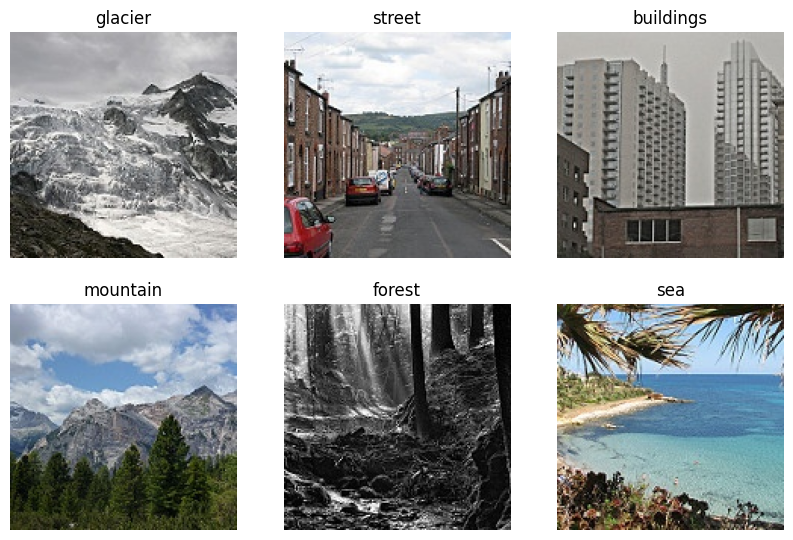

In [7]:
from PIL import Image
import random

plt.figure(figsize=(10,10))
for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, random.choice(os.listdir(os.path.join(train_dir, cls))))
    img = Image.open(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.show()

# Data Preprocessing & Augmentation

In [8]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

In [10]:
train_data = ImageFolder(train_dir, transform=train_transforms)
test_data = ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes

# Baseline CNN Model

In [11]:
import torch.nn as nn
import torch.optim as optim

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [13]:
# Check GPU
import torch
torch.cuda.is_available()

True

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop

In [15]:
def train_model(model, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

In [16]:
train_model(model, epochs=5)

Epoch 1/5, Loss: 1.1525
Epoch 2/5, Loss: 0.8151
Epoch 3/5, Loss: 0.6916
Epoch 4/5, Loss: 0.6257
Epoch 5/5, Loss: 0.5652


# Transfer Learning (ResNet50)

In [17]:
from torchvision import models

In [18]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 96.0MB/s]


In [19]:
train_model(resnet, epochs=5)

Epoch 1/5, Loss: 0.9650
Epoch 2/5, Loss: 0.5176
Epoch 3/5, Loss: 0.4224
Epoch 4/5, Loss: 0.3809
Epoch 5/5, Loss: 0.3550


# Model Evaluation

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [21]:
def evaluate_model(model):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))

In [22]:
evaluate_model(resnet)

              precision    recall  f1-score   support

   buildings       0.90      0.90      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.84      0.81      0.83       553
    mountain       0.85      0.81      0.83       525
         sea       0.87      0.95      0.91       510
      street       0.92      0.91      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



# Grad-CAM Explainability

In [23]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=6893fab27d0687e92ffefcee664341373c39d61f9ef1864fad9647e13a8bac57
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [24]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [25]:
target_layer = resnet.layer4[-1]
cam = GradCAM(model=resnet, target_layers=[target_layer])

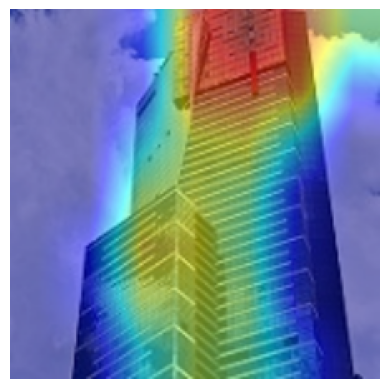

In [27]:
import cv2

# Ensure the model is in evaluation mode
resnet.eval()

image, label = test_data[0]
input_tensor = image.unsqueeze(0).to(device)

# The GradCAM library needs to calculate gradients with respect to the output of `target_layer`.
# If the parameters of `target_layer` (or layers upstream) have `requires_grad=False`,
# PyTorch's autograd engine won't compute gradients for its output.
# Since the entire `resnet` backbone was frozen (param.requires_grad = False),
# `target_layer` (resnet.layer4[-1]) also has its parameters frozen, leading to `grads=None`.

# To fix this, we can temporarily enable gradients for the target layer parameters.
original_requires_grad_states = {}
for param in target_layer.parameters():
    original_requires_grad_states[param] = param.requires_grad
    param.requires_grad = True # Temporarily enable gradients

grayscale_cam = cam(input_tensor=input_tensor)[0]

# Restore original requires_grad states
for param, state in original_requires_grad_states.items():
    param.requires_grad = state

# Move image to CPU and convert to numpy for visualization
rgb_img = image.permute(1,2,0).cpu().numpy()

# Denormalize rgb_img for better visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
rgb_img = std * rgb_img + mean # Undo normalization
rgb_img = np.clip(rgb_img, 0, 1) # Clip to [0,1] range

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.axis("off")
plt.show()

🔴 Red / Yellow → Most important regions for the prediction

🟢 Green → Moderately important

🔵 Blue → Little or no influence

**Why this predicts “buildings”**

The model has learned that:

Tall vertical geometry

Repeated window/line patterns

Rigid edges

are strong signals of buildings, not:

Forest (irregular textures)

Sea (smooth horizontal regions)

Mountain (organic shapes)